# Generate a prettier plot with statistics on the plot

In [1]:
library(repr)
library(ggpubr)
library(tidyverse)

Loading required package: ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
config <- list('caudate'= '../../../caudate/_m/genes/diffExpr_maleVfemale_full.txt',
               'dlpfc'= '../../../dlpfc/_m/genes/diffExpr_maleVfemale_full.txt', 
               'hippo'= '../../../hippocampus/_m/genes/diffExpr_maleVfemale_full.txt', 
               'cmc_dlpfc'= '../../../cmc_dlpfc/_m/mssm_penn_pitt_maleVfemale.tsv',
               'cmc_hbcc'= '../../../cmc_dlpfc/_m/nimh_hbcc_maleVfemale.tsv')

In [3]:
get_deg <- function(fn){
    dft <- data.table::fread(fn)
    if('gene_id' %in% colnames(dft)){
        dft <- dft %>% 
            mutate(Feature=gene_id, Dir=sign(t)) %>% 
            rename(ensemblID=ensembl_gene_id) %>%
            select('Feature', 'ensemblID', 'adj.P.Val', 'logFC', 't', 'Dir')
    } else if('Geneid' %in% colnames(dft)) {
        dft <- dft %>% 
            mutate(Feature=Geneid, Dir=sign(t), 
                   ensemblID=str_replace(Geneid, "\\..*", "")) %>% 
            select('Feature', 'ensemblID', 'adj.P.Val', 'logFC', 't', 'Dir')
    } else {
        dft <- dft %>% 
            mutate(Feature=V1, Dir=sign(t)) %>% 
            select('Feature', 'ensemblID', 'adj.P.Val', 'logFC', 't', 'Dir')
    }
    return(dft)
}

get_deg_sig <- function(fn, fdr){
    dft <- get_deg(fn)
    return(subset(dft, adj.P.Val < fdr))
}

merge_dataframe <- function(tissue1, tissue2){
    return(merge(get_deg(config[[tissue1]]), get_deg(config[[tissue2]]), 
                 by='Feature', suffixes=c(paste0('_',tissue1), paste0('_',tissue2))))
}

merge_dataframes_sig <- function(tissue1, tissue2){
    fdr = 0.05
    return(merge(get_deg_sig(config[[tissue1]], fdr), get_deg_sig(config[[tissue2]], fdr), 
                 by='Feature', suffixes=c(paste0('_',tissue1), paste0('_',tissue2))))
}

tissue_annotation <- function(tissue){
    return(list('dlpfc'='DLPFC', 'hippo'='Hippocampus', 
                'caudate'='Caudate', 'cmc_dlpfc'='CMC DLPFC', 
                'cmc_hbcc'='CMC DLPFC: HBCC')[[tissue]])
}

get_scatter_plot <- function(tissue1, tissue2, merge_fnc, coords){
    dft <- merge_fnc(tissue1, tissue2)
    sp = ggscatter(dft, x=paste0('t_', tissue1), y=paste0('t_', tissue2), add="reg.line", 
                   xlab=paste0('T-statistic (',tissue_annotation(tissue1), ')'),
                   ylab=paste0('T-statistic (',tissue_annotation(tissue2), ')'),
                   add.params = list(color = "blue", fill = "lightgray"), conf.int = FALSE, 
                   cor.method = "pearson", cor.coef = FALSE, cor.coef.size = 7, 
                   cor.coeff.args = list(label.sep = "\n"),  #cor.coef.coord = coords, 
                   ylim=c(-125, 125)) + 
    stat_cor(aes(label = paste0(..rr.label..)), size=8, method = "pearson") + 
    font("xylab", size = 20, face='bold') + font("xy.text", size = 18)
    return(sp)
}


save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



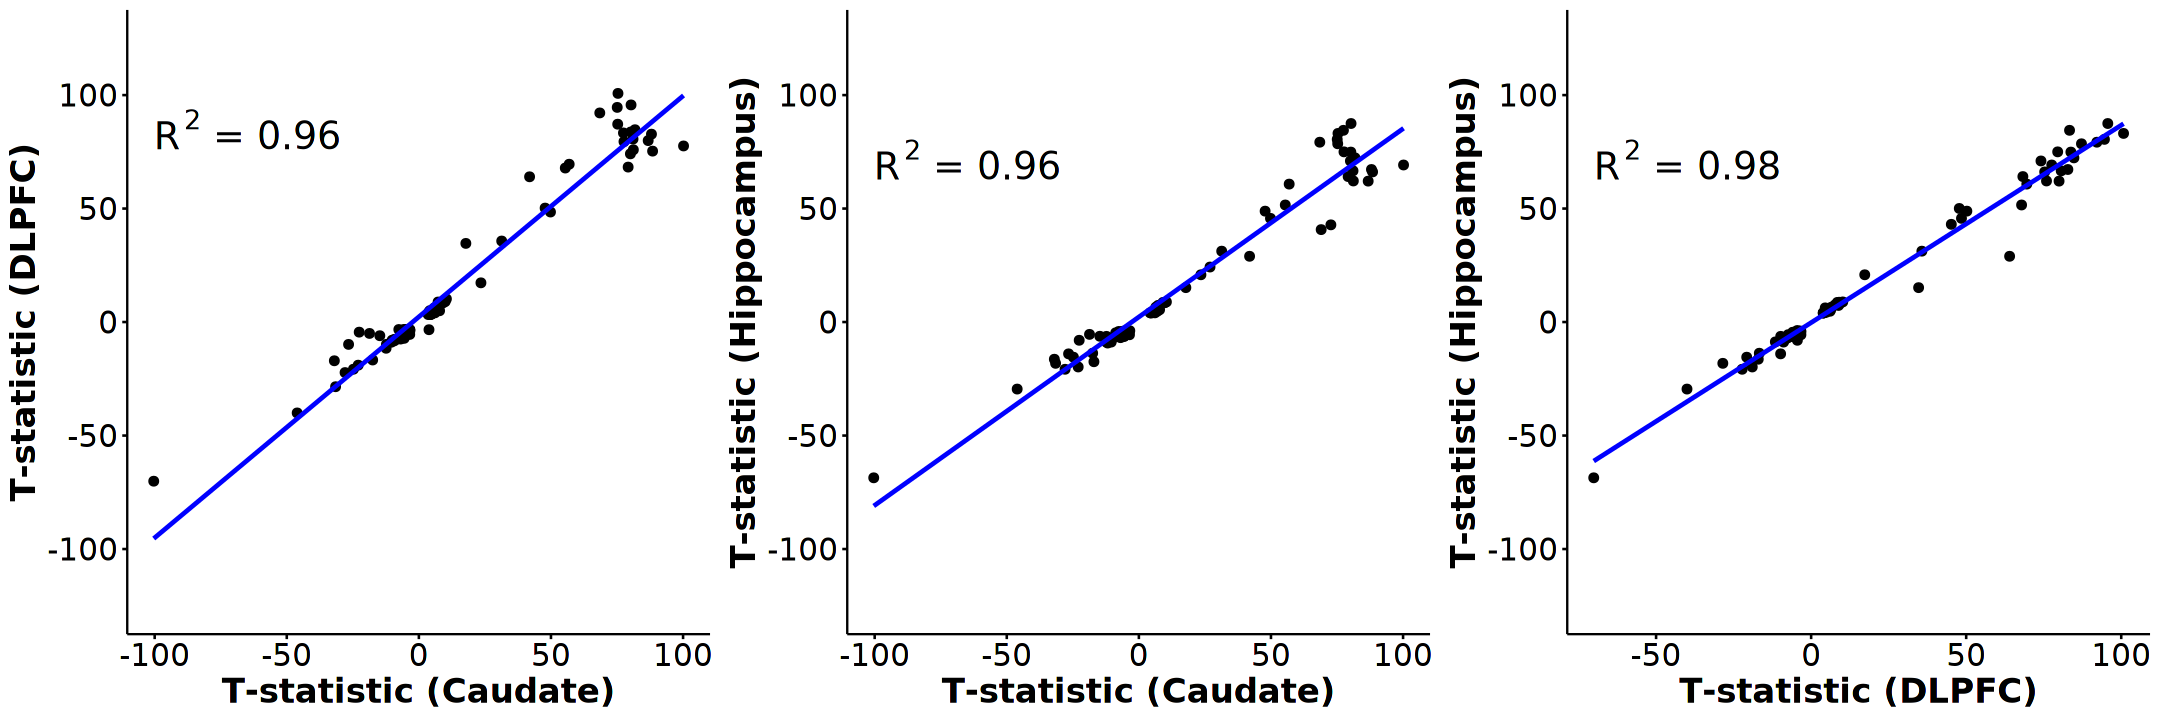

In [4]:
options(repr.plot.width=18, repr.plot.height=6)
sp1_sig = get_scatter_plot('caudate', 'dlpfc', merge_dataframes_sig, c(-110, 85))
sp2_sig = get_scatter_plot('caudate', 'hippo', merge_dataframes_sig, c(-110, 85))
sp3_sig = get_scatter_plot('dlpfc', 'hippo', merge_dataframes_sig, c(-110, 85))
fig1 = ggarrange(sp1_sig, sp2_sig, sp3_sig, ncol=3, align='v')
print(fig1)

In [5]:
save_ggplots("tstatistic_corr_sig", fig1, 18, 6)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



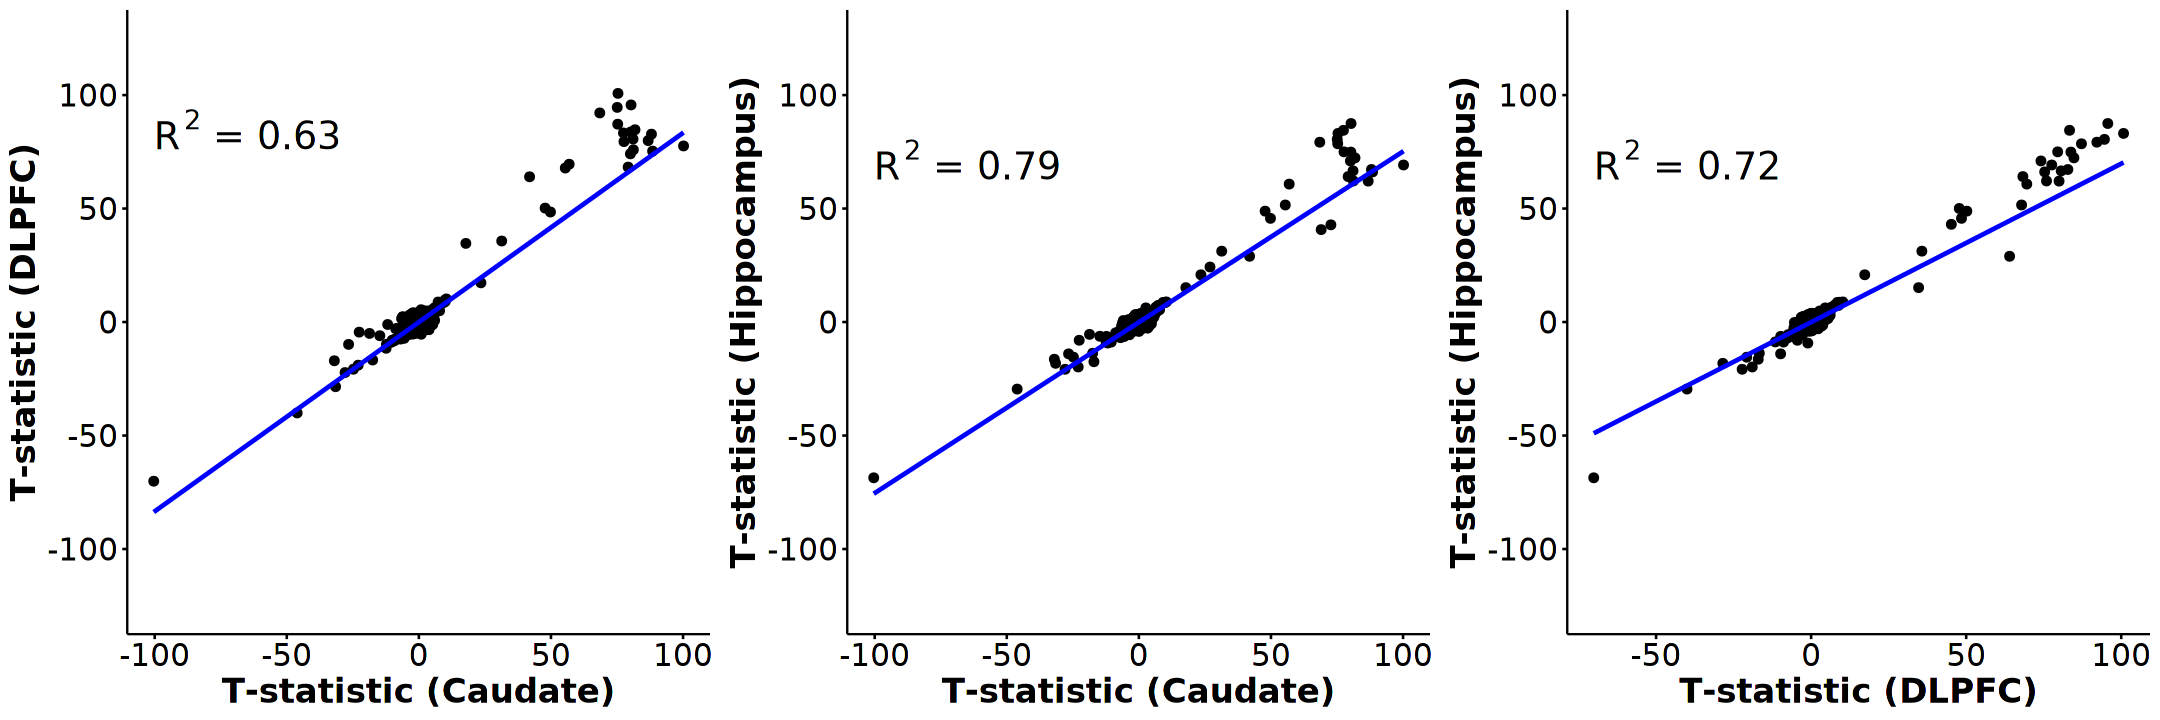

In [6]:
sp1 = get_scatter_plot('caudate', 'dlpfc', merge_dataframe, c(-110, 85))
sp2 = get_scatter_plot('caudate', 'hippo', merge_dataframe, c(-110, 85))
sp3 = get_scatter_plot('dlpfc', 'hippo', merge_dataframe, c(-110, 85))
fig2 = ggarrange(sp1, sp2, sp3, ncol=3, align='v')
print(fig2)

In [7]:
save_ggplots("tstatistic_corr", fig2, 18, 6)

## CommonMind comparison: MSSM Penn Pitt

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



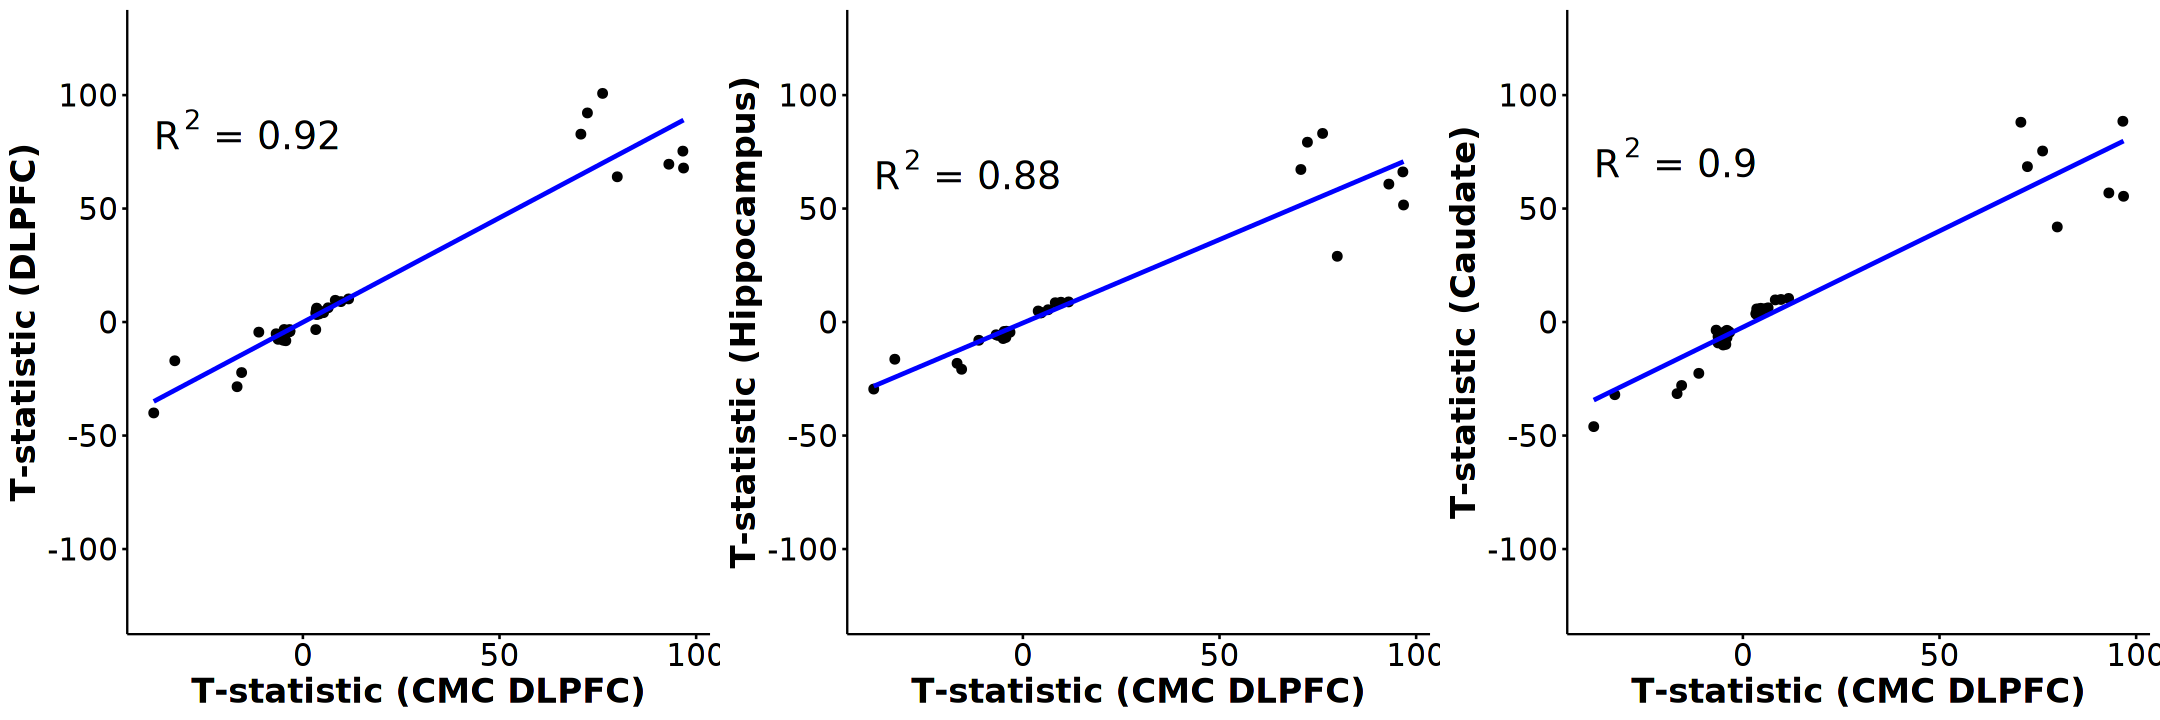

In [8]:
sp4_sig = get_scatter_plot('cmc_dlpfc', 'dlpfc', merge_dataframes_sig, c(-55, 85))
sp5_sig = get_scatter_plot('cmc_dlpfc', 'hippo', merge_dataframes_sig, c(-55, 85))
sp6_sig = get_scatter_plot('cmc_dlpfc', 'caudate', merge_dataframes_sig, c(-55, 85))
fig3 = ggarrange(sp4_sig, sp5_sig, sp6_sig, ncol=3, align='v')
print(fig3)

In [9]:
save_ggplots("cmc_tstatistic_corr_sig", fig3, 18, 6)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



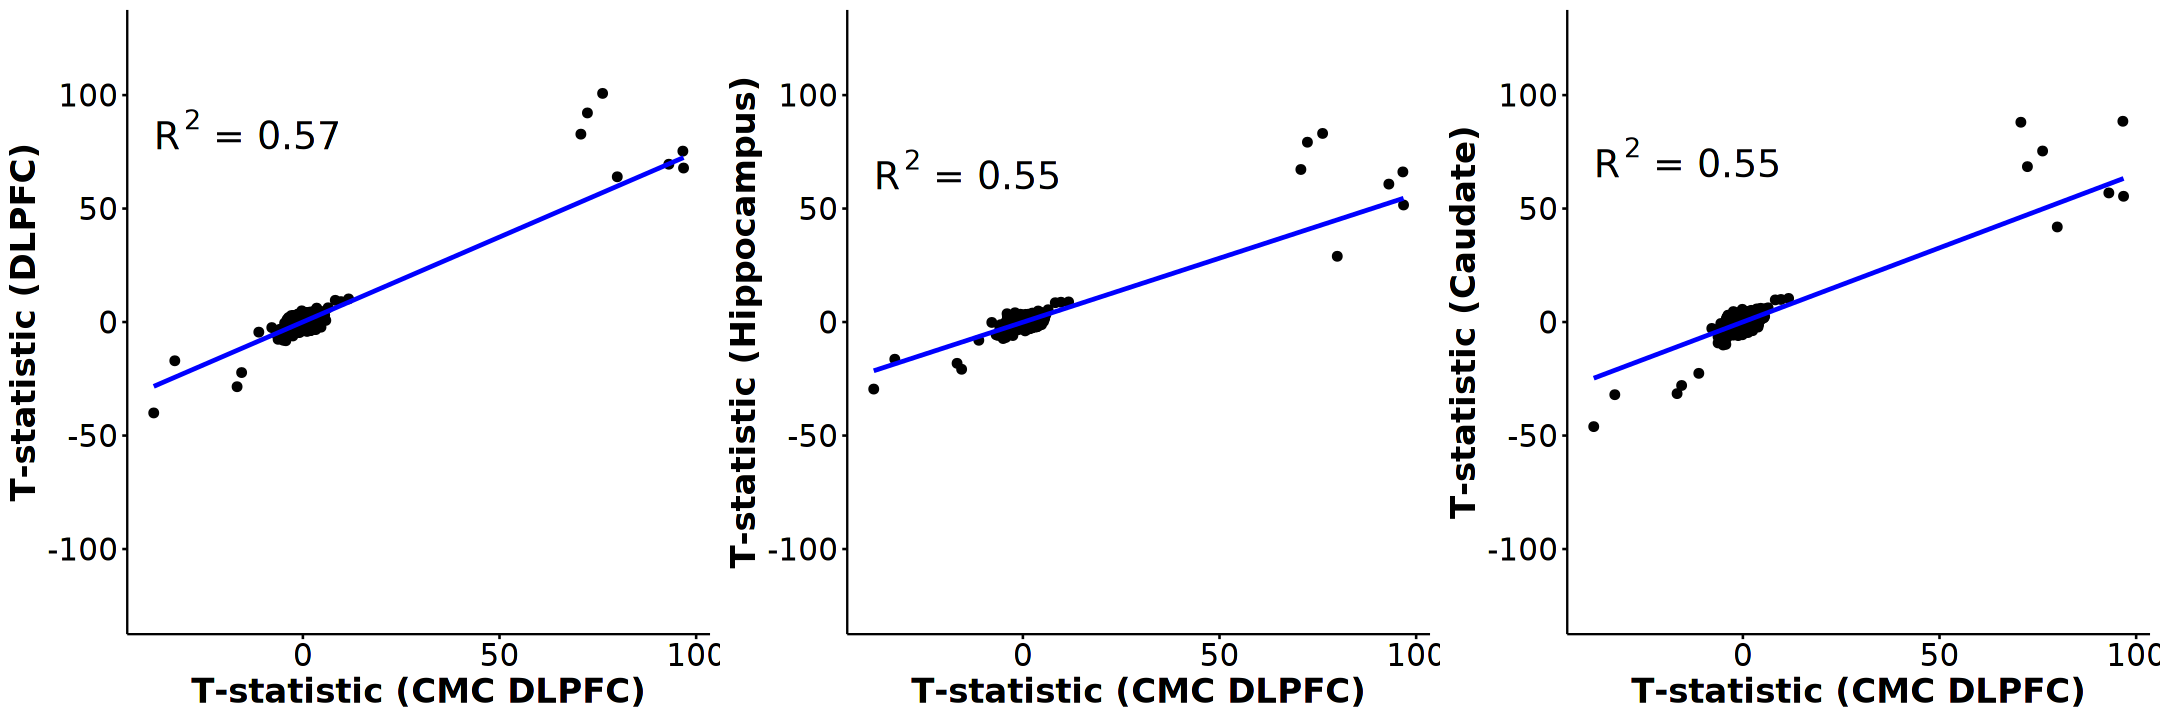

In [10]:
sp4 = get_scatter_plot('cmc_dlpfc', 'dlpfc', merge_dataframe, c(-55, 85))
sp5 = get_scatter_plot('cmc_dlpfc', 'hippo', merge_dataframe, c(-55, 85))
sp6 = get_scatter_plot('cmc_dlpfc', 'caudate', merge_dataframe, c(-55, 85))
fig4 = ggarrange(sp4, sp5, sp6, ncol=3)
print(fig4)

In [11]:
save_ggplots("cmc_tstatistic_corr", fig4, 18, 6)

## CommonMind comparison: NIMH HBCC

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



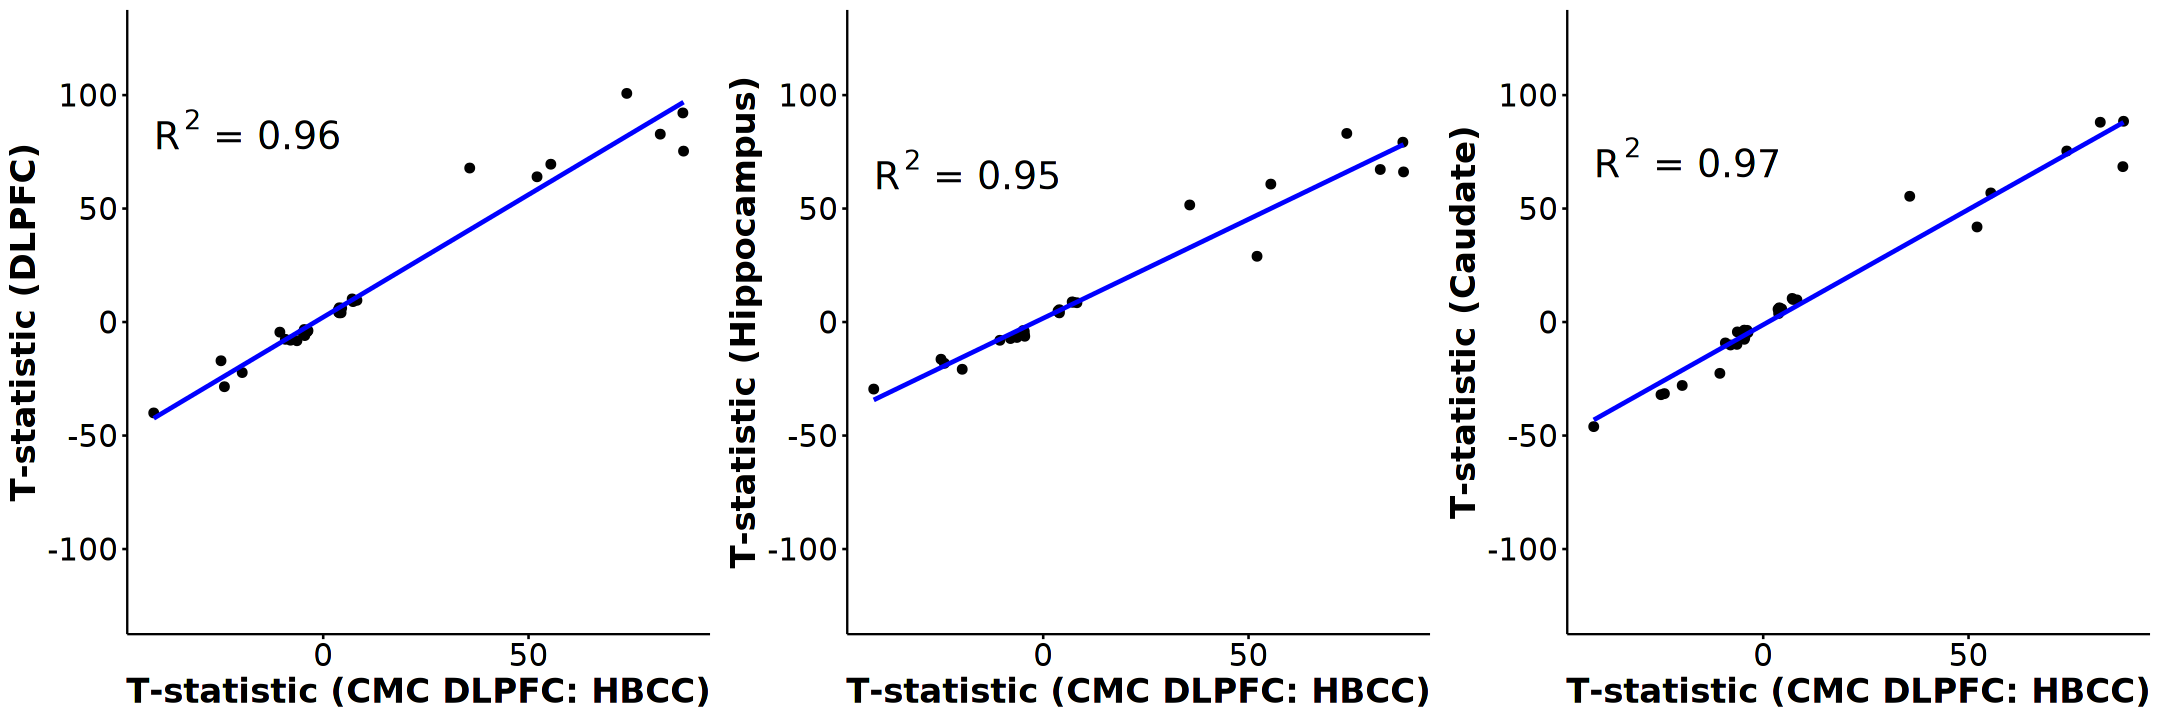

In [12]:
sp4_sig = get_scatter_plot('cmc_hbcc', 'dlpfc', merge_dataframes_sig, c(-55, 85))
sp5_sig = get_scatter_plot('cmc_hbcc', 'hippo', merge_dataframes_sig, c(-55, 85))
sp6_sig = get_scatter_plot('cmc_hbcc', 'caudate', merge_dataframes_sig, c(-55, 85))
fig3 = ggarrange(sp4_sig, sp5_sig, sp6_sig, ncol=3, align='v')
print(fig3)

In [13]:
save_ggplots("cmc_hbcc_tstatistic_corr_sig", fig3, 18, 6)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



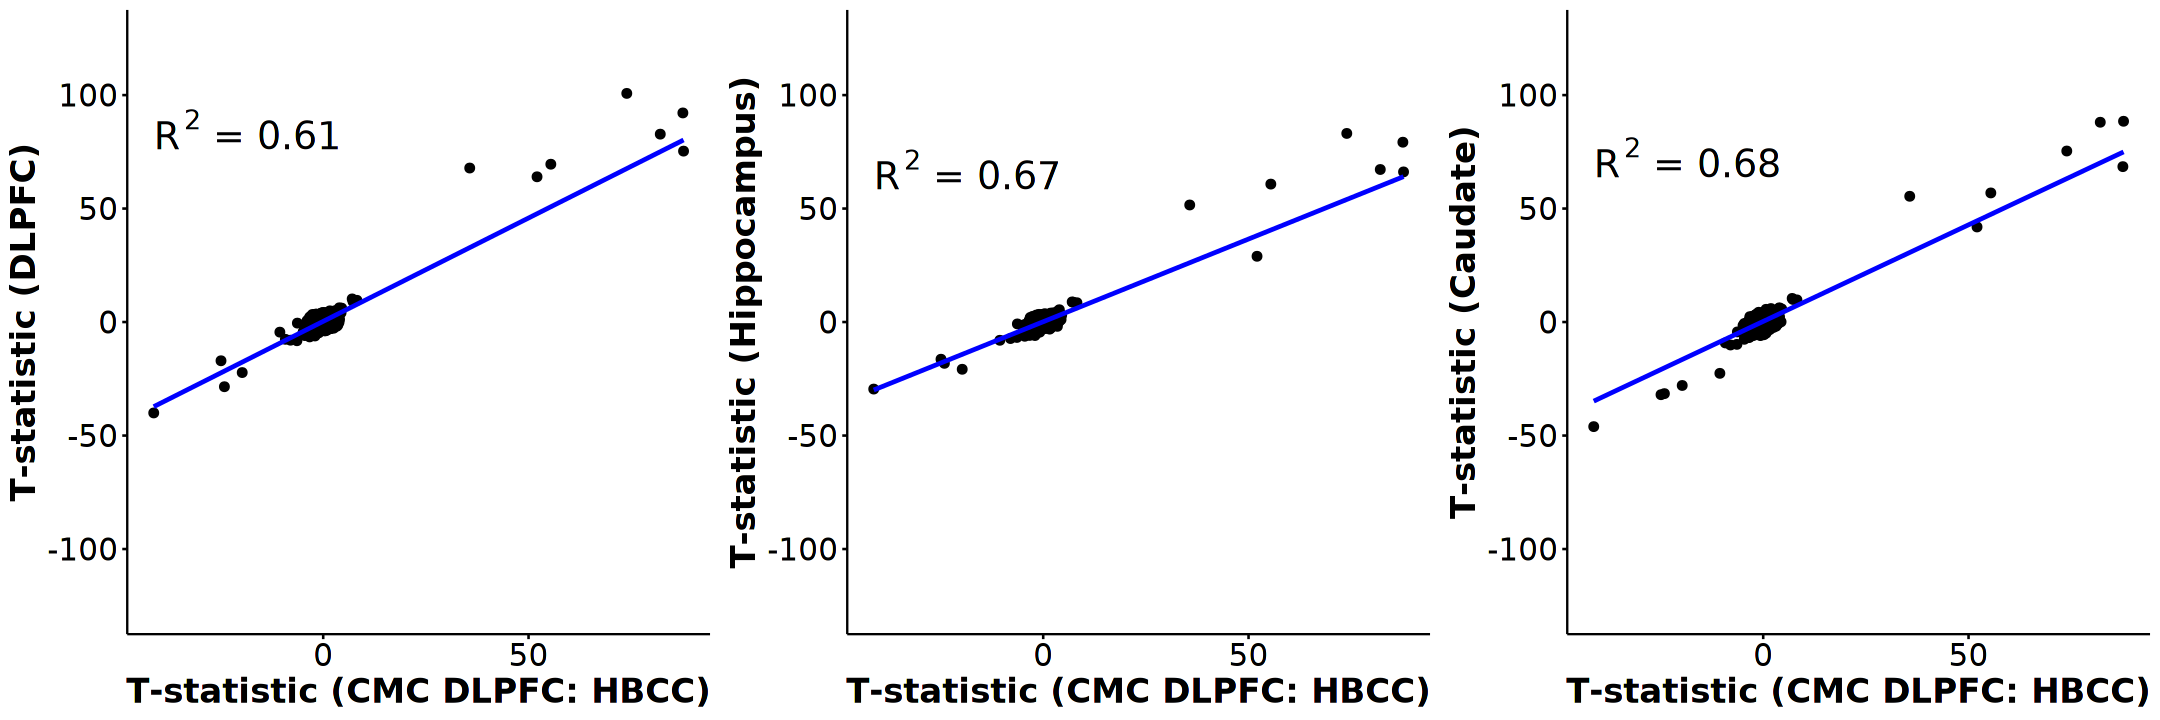

In [14]:
sp4 = get_scatter_plot('cmc_hbcc', 'dlpfc', merge_dataframe, c(-55, 85))
sp5 = get_scatter_plot('cmc_hbcc', 'hippo', merge_dataframe, c(-55, 85))
sp6 = get_scatter_plot('cmc_hbcc', 'caudate', merge_dataframe, c(-55, 85))
fig4 = ggarrange(sp4, sp5, sp6, ncol=3)
print(fig4)

In [15]:
save_ggplots("cmc_hbcc_tstatistic_corr", fig4, 18, 6)

## Reproducibility Information

In [16]:
print("Reproducibility Information:")
Sys.time()
proc.time()
options(width=120)
sessioninfo::session_info()

[1] "Reproducibility Information:"


[1] "2021-07-13 11:01:42 EDT"

   user  system elapsed 
 53.615   1.402  38.393 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.3 (2020-10-10)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2021-07-13                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package     * version  date       lib source        
 abind         1.4-5    2016-07-21 [1] CRAN (R 4.0.2)
 assertthat    0.2.1    2019-03-21 [1] CRAN (R 4.0.2)
 backports     1.2.1    2020-12-09 [1] CRAN (R 4.0.2)
 base64enc     0.1-3    2015-07-28 [1] CRAN (R 4.0.2)
 broom         0.7.8    2021-06-24 [1] CRAN (R 4.0.3)
 Cairo         1.5-12.2 2020-07-07 [1] CRAN (R 